In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Baixando Funções que serão usadas nesse notebook")
    ! shred -u astroFunctions.py
    ! wget https://raw.githubusercontent.com/rafaelmgr12/PHOTOzxcorr/main/functions/ml_functions.py -O ml_functions.py
    ! wget
    ! pip install esutil
    ! pip install healpy
    import astroFunctions as astro
    from google.colab import drive
    drive.mount('/content/drive')
else:
    import sys,os
    home = os.getenv("HOME")
    sys.path.append(home+"/Programs/GPz/python") # user here the path where we download the folder GPz
    import GPz

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os,sys
import matplotlib
from astropy.table import Table,QTable
from sklearn.model_selection import cross_val_score, KFold, train_test_split,ShuffleSplit
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde
from scipy import stats

dataPath = home+'/Projetos/master-thesis/data/vipers.fits'    # path to the data set, has to be in the following format m_1,m_2,..,m_k,e_1,e_2,...,e_k,z_spec
                                                        # where m_i is the i-th magnitude, e_i is its associated uncertainty and z_spec is the spectroscopic redshift
                                                        # [required]

In [3]:
data = Table.read(dataPath).to_pandas()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47658 entries, 0 to 47657
Columns: 224 entries, ID to random
dtypes: float32(2), float64(184), int32(2), int64(31), object(5)
memory usage: 80.7+ MB


In [5]:
maxIter = 500                  # maximum number of iterations [default=200]
maxAttempts = 50               # maximum iterations to attempt if there is no progress on the validation set [default=infinity]
trainSplit = 0.5               # percentage of data to use for training
validSplit = 0.2               # percentage of data to use for validation
testSplit  = 0.3               # percentage of data to use for testing

In [6]:
feat = ['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',
        'MAG_AUTO_G_DERED','MAG_AUTO_R_DERED','MAG_AUTO_I_DERED','MAG_AUTO_Z_DERED','MAG_AUTO_Y_DERED',
        "WAVG_MAG_PSF_G","WAVG_MAG_PSF_R","WAVG_MAG_PSF_I","WAVG_MAG_PSF_Z","WAVG_MAG_PSF_Y"
       ,'WAVG_MAG_PSF_G_DERED','WAVG_MAG_PSF_R_DERED','WAVG_MAG_PSF_I_DERED','WAVG_MAG_PSF_Z_DERED','WAVG_MAG_PSF_Y_DERED']


In [7]:
data.loc[data[feat[0]]==99,feat[0]] = data[data[feat[0]]!=99][feat[0]].max()
data.loc[data[feat[1]]==99,feat[1]] = data[data[feat[1]]!=99][feat[1]].max()
data.loc[data[feat[2]]==99,feat[2]] = data[data[feat[2]]!=99][feat[2]].max()
data.loc[data[feat[3]]==99,feat[3]] = data[data[feat[3]]!=99][feat[3]].max()
data.loc[data[feat[4]]==99,feat[4]] = data[data[feat[4]]!=99][feat[4]].max()
data.loc[data[feat[5]]>90,feat[5]] = data[data[feat[5]]<90][feat[5]].max()
data.loc[data[feat[6]]>90,feat[6]] = data[data[feat[6]]<90][feat[6]].max()
data.loc[data[feat[7]]>90,feat[7]] = data[data[feat[7]]<90][feat[7]].max()
data.loc[data[feat[8]]>90,feat[8]] = data[data[feat[8]]<90][feat[8]].max()
data.loc[data[feat[9]]>90,feat[9]] = data[data[feat[9]]<90][feat[9]].max()
data.loc[data[feat[10]]>90,feat[10]] = data[data[feat[10]]<90][feat[10]].max()
data.loc[data[feat[11]]>90,feat[11]] = data[data[feat[11]]<90][feat[11]].max()
data.loc[data[feat[12]]>90,feat[12]] = data[data[feat[12]]<90][feat[12]].max()
data.loc[data[feat[13]]>90,feat[13]] = data[data[feat[13]]<90][feat[13]].max()
data.loc[data[feat[14]]>90,feat[14]] = data[data[feat[14]]<90][feat[14]].max()
data.loc[data[feat[15]]>90,feat[15]] = data[data[feat[15]]<90][feat[15]].max()
data.loc[data[feat[16]]>90,feat[16]] = data[data[feat[16]]<90][feat[16]].max()
data.loc[data[feat[17]]>90,feat[17]] = data[data[feat[17]]<90][feat[17]].max()
data.loc[data[feat[18]]>90,feat[18]] = data[data[feat[18]]<90][feat[18]].max()
data.loc[data[feat[19]]>90,feat[19]] = data[data[feat[19]]<90][feat[19]].max()

In [8]:
X = data[['MAG_AUTO_G_DERED','MAG_AUTO_R_DERED','MAG_AUTO_I_DERED','MAG_AUTO_Z_DERED','MAG_AUTO_Y_DERED']].values
Y = data["z"].values.reshape(-1,1)

err = data[["MAGERR_AUTO_G","MAGERR_AUTO_R","MAGERR_AUTO_I","MAGERR_AUTO_Z","MAGERR_AUTO_Y"]].values

X = np.concatenate((X,err),axis = 1 )
print(X.shape,"\n",Y.shape)

(47658, 10) 
 (47658, 1)


In [9]:
########### Model options ###############

method = 'VC'               # select method, options = GL, VL, GD, VD, GC and VC [required]
                            #
m = 25                      # number of basis functions to use [required]
                            #
joint = True                # jointly learn a prior linear mean function [default=true]
                            #
heteroscedastic = True      # learn a heteroscedastic noise process, set to false interested only in point estimates
                            #
csl_method = 'normal'       # cost-sensitive learning option: [default='normal']
                            #       'balanced':     to weigh rare samples more heavly during train
                            #       'normalized':   assigns an error cost for each sample = 1/(z+1)
                            #       'normal':       no weights assigned, all samples are equally important
                            #
binWidth = 0.1              # the width of the bin for 'balanced' cost-sensitive learning [default=range(z_spec)/100]

decorrelate = True          # preprocess the data using PCA [default=False]

In [10]:
n,d = X.shape

filters = int(d/2)

# log the uncertainties of the magnitudes, any additional preprocessing should be placed here
X[:, filters:] = np.log(X[:, filters:])

# sample training, validation and testing sets from the data
training,validation,testing = GPz.sample(n,trainSplit,validSplit,testSplit)

# you can also select the size of each sample
# training,validation,testing = GPz.sample(n,10000,10000,10000)

# get the weights for cost-sensitive learning
omega = GPz.getOmega(Y, method=csl_method)


# initialize the initial model
model = GPz.GP(m,method=method,joint=joint,heteroscedastic=heteroscedastic,decorrelate=decorrelate)

# train the model
model.train(X.copy(), Y.copy(), omega=omega, training=training, validation=validation, maxIter=maxIter, maxAttempts=maxAttempts)

########### NOTE ###########
# you can train the model gain, eve using different data, by executing:
# model.train(model,X,Y,options)

# use the model to generate predictions for the test set
mu,sigma,modelV,noiseV,PHI = model.predict(X[testing,:].copy())




Iter	 logML/n 		 Train RMSE		 Train RMSE/n		 Valid RMSE		 Valid MLL		 Time    
   1	 4.3294153e-01	 1.3523531e-01	 4.4509738e-01	 1.3824998e-01	[ 4.0802087e-01]	 9.5855808e-01
   2	 4.4725912e-01	 1.3265538e-01	 4.5647106e-01	 1.3566854e-01	[ 4.1296512e-01]	 2.1200430e+00
   3	 4.6136396e-01	 1.3178960e-01	 4.7008223e-01	 1.3495451e-01	[ 4.2383290e-01]	 2.1394284e+00
   4	 4.7896829e-01	 1.3171808e-01	 4.8725776e-01	 1.3494770e-01	[ 4.4215545e-01]	 2.3444939e+00
   5	 5.0702779e-01	 1.3153545e-01	 5.1521091e-01	 1.3470249e-01	[ 4.7473031e-01]	 2.1336768e+00
   6	 5.4397995e-01	 1.3157330e-01	 5.5195497e-01	 1.3525745e-01	[ 5.1203981e-01]	 2.0791080e+00
   7	 5.7104058e-01	 1.3239694e-01	 5.7957231e-01	 1.3572499e-01	[ 5.4616827e-01]	 2.0740304e+00
   8	 5.9458798e-01	 1.3170877e-01	 6.0233923e-01	 1.3596559e-01	[ 5.7045679e-01]	 2.0771692e+00
   9	 5.9605616e-01	 1.3242986e-01	 6.0475024e-01	 1.3667362e-01	[ 5.7545374e-01]	 2.0490398e+00
  10	 6.0602286e-01	 1.3116863e-01	 6.1528457e-0

In [11]:
########### Display Results ###########

# compute metrics
rmse = np.sqrt(GPz.metrics(Y[testing],mu,sigma,lambda y,mu,sigma: (y-mu)**2))
mll = GPz.metrics(Y[testing],mu,sigma,lambda y,mu,sigma: -0.5*(y-mu)**2/sigma-0.5*np.log(sigma)-0.5*np.log(2*np.pi))
fr15 = GPz.metrics(Y[testing],mu,sigma,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.15))
fr05 = GPz.metrics(Y[testing],mu,sigma,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.05))
bias = GPz.metrics(Y[testing],mu,sigma,lambda y,mu,sigma: y-mu)

# print metrics for the entire data
print ('{0:4s}\t\t\t{1:3s}\t\t\t{2:6s}\t\t\t{3:6s}\t\t\t{4:4s}'.format('RMSE', ' MLL', ' FR15', ' FR05', ' BIAS'))
print ('{0:1.7e}\t{1: 1.7e}\t{2: 1.7e}\t{3: 1.7e}\t{4: 1.7e}'.format(rmse[-1], mll[-1], fr15[-1],fr05[-1],bias[-1]))

RMSE			 MLL			 FR15 			 FR05 			 BIAS
1.2869040e-01	 8.2883080e-01	 9.5936495e+01	 6.9660092e+01	 1.8017941e-03


In [12]:
rmse[-1]

0.12869039842370694

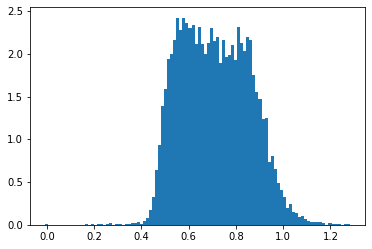

In [13]:
plt.hist(mu,bins = 100,density=True,);

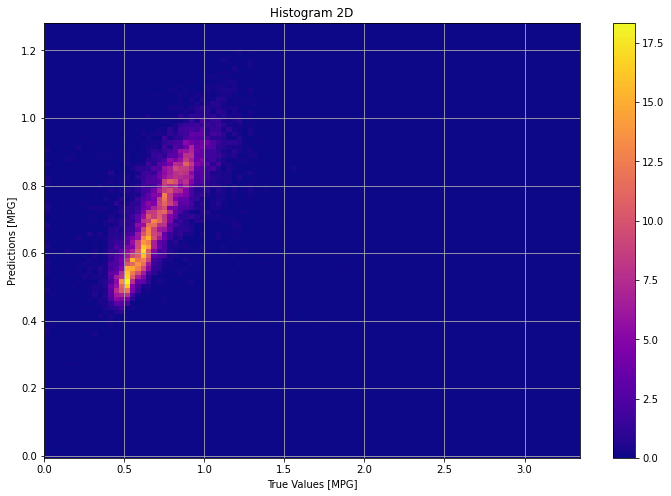

In [14]:
plt.figure(figsize = (12,8))
plt.title("Histogram 2D")
plt.hist2d(Y[testing].flatten(),mu.flatten(), bins= 100,density=True,cmap = "plasma")
plt.colorbar()
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.grid()
#plt.show()
plt.savefig("plots/gpz_hist2d.png")
#plt.close()

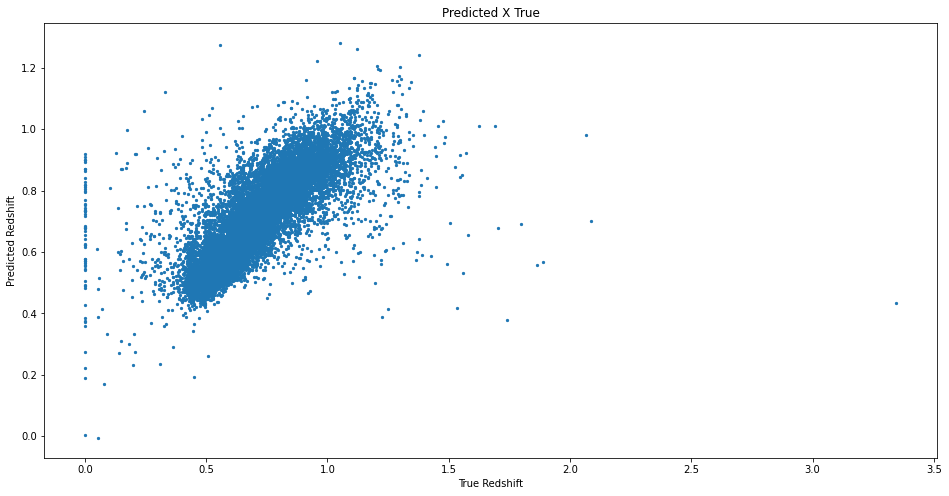

In [15]:
plt.figure(figsize=(16,8))
plt.title("Predicted X True")
plt.scatter(Y[testing],mu,s=5)
plt.xlabel("True Redshift")
plt.ylabel("Predicted Redshift")
plt.savefig("plots/gpz_hist2d.png", dpi = 300)

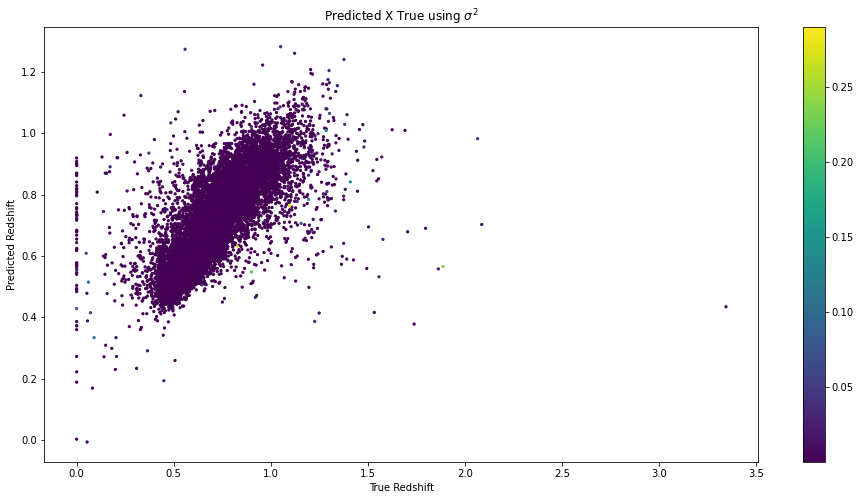

In [16]:
plt.figure(figsize=(16,8))
plt.title("Predicted X True using $\sigma^2$")
plt.scatter(Y[testing],mu,s=5,c=(np.squeeze(sigma))**2)
plt.xlabel("True Redshift")
plt.ylabel("Predicted Redshift")
plt.colorbar()

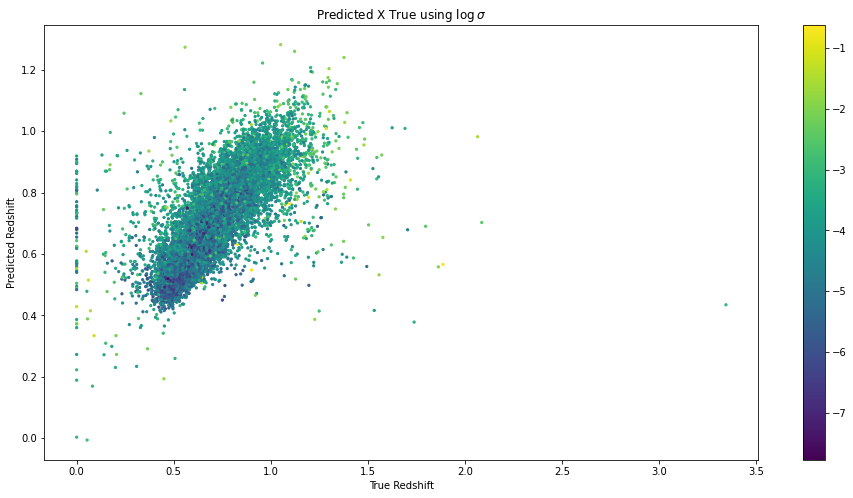

In [17]:
plt.figure(figsize=(16,8))
plt.title("Predicted X True using $\log\sigma$")
plt.scatter(Y[testing],mu,s=5,c=np.log(np.squeeze(sigma)))
plt.xlabel("True Redshift")
plt.ylabel("Predicted Redshift")
plt.colorbar()

In [18]:
Y[testing,:].shape

(14298, 1)

In [19]:
mu.shape

(14298, 1)

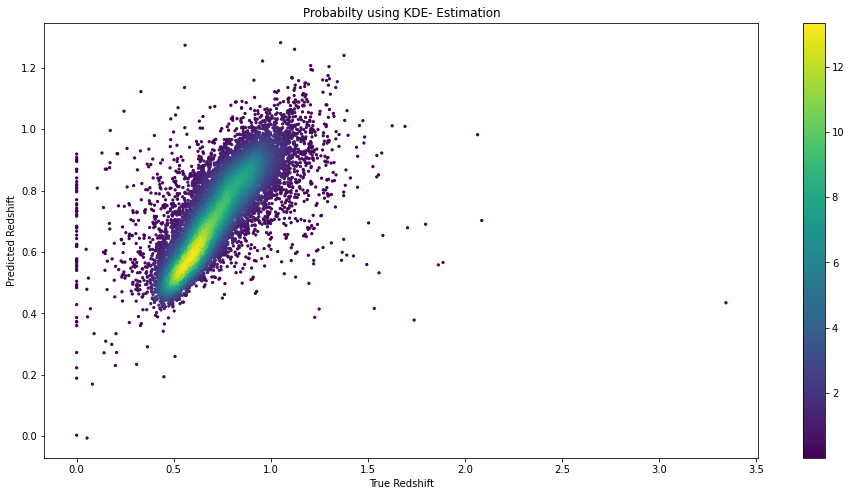

In [20]:
plt.figure(figsize=(16,8))
plt.title("Probabilty using KDE- Estimation")
xy = np.hstack([Y[testing,:],mu]).T
z = gaussian_kde(xy)(xy)
plt.scatter(Y[testing,:],mu,c=z,s=5)
plt.xlabel("True Redshift")
plt.ylabel("Predicted Redshift")
plt.colorbar()
plt.savefig("plots/gpz_scatterprobs.png")

In [21]:
x = np.array(range(0,20+1))*5
x[0]=1

ind = x*len(rmse)//100

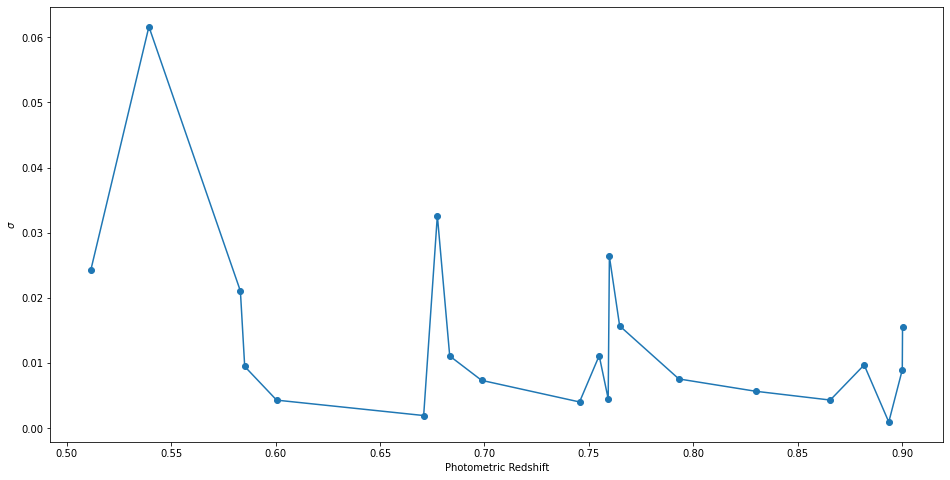

In [22]:
plt.figure(figsize=(16,8))
plt.plot(np.sort(mu[ind-1],0),sigma[ind-1],'o-')
plt.xlabel('Photometric Redshift')
plt.ylabel('$\sigma$')
plt.show()

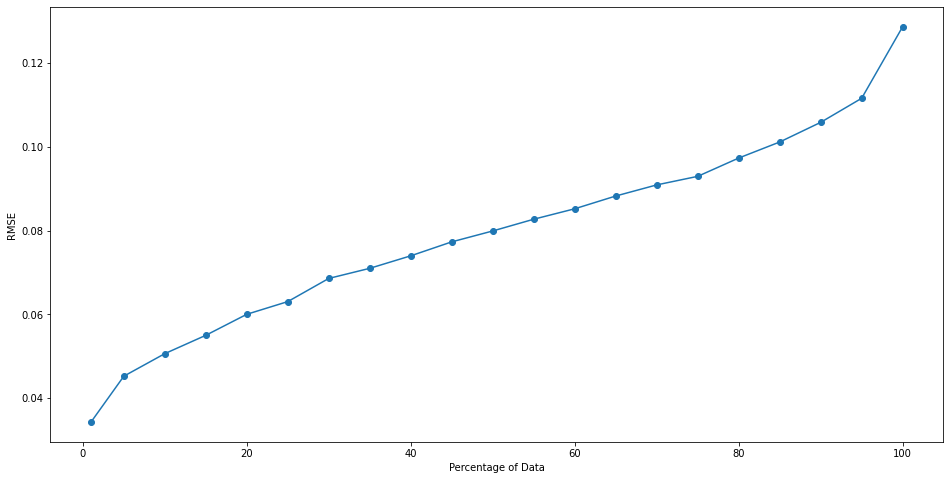

In [23]:
plt.figure(figsize=(16,8))
plt.plot(x,rmse[ind-1],'o-')
plt.xlabel('Percentage of Data')
plt.ylabel('RMSE')
plt.show()

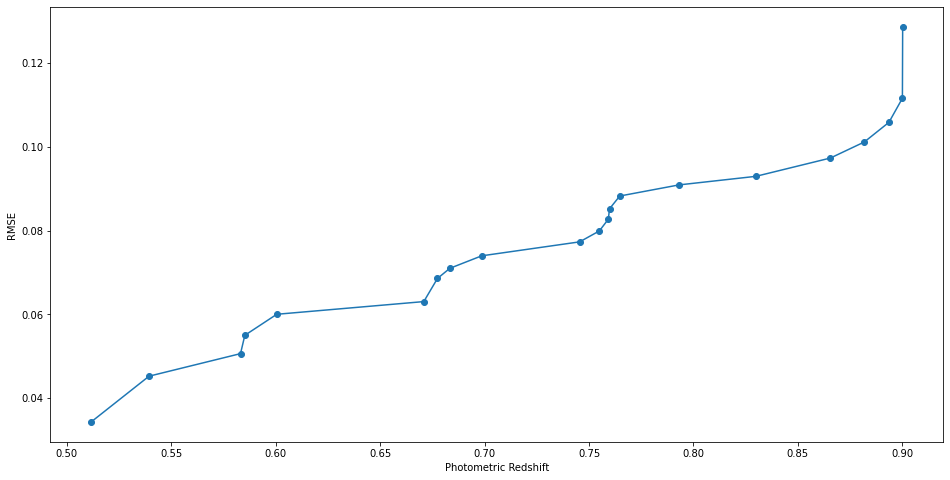

In [24]:
plt.figure(figsize=(16,8))
plt.plot(np.sort(mu[ind-1],0),rmse[ind-1],'o-')
plt.xlabel('Photometric Redshift')
plt.ylabel('RMSE')
plt.show()

Text(0, 0.5, 'MLL')

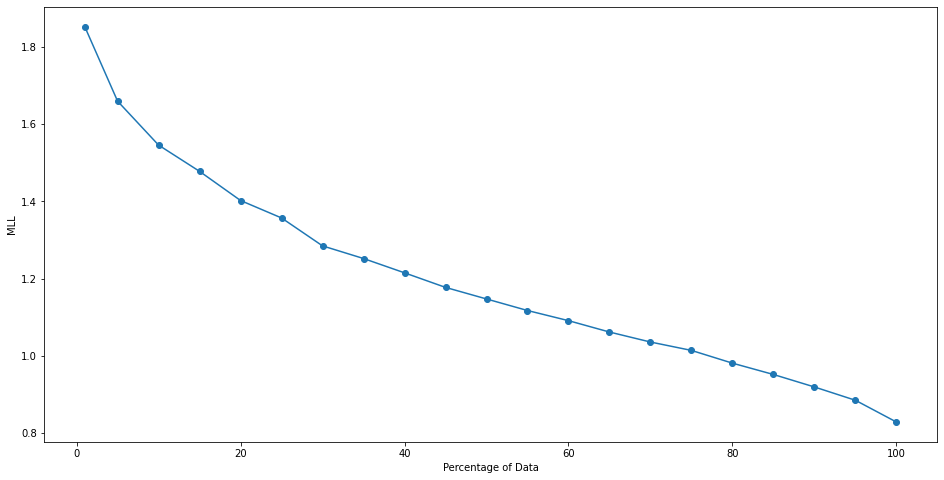

In [25]:
plt.figure(figsize=(16,8))
plt.plot(x,mll[ind-1],'o-')
plt.xlabel('Percentage of Data')
plt.ylabel('MLL')

Text(0, 0.5, 'FR15')

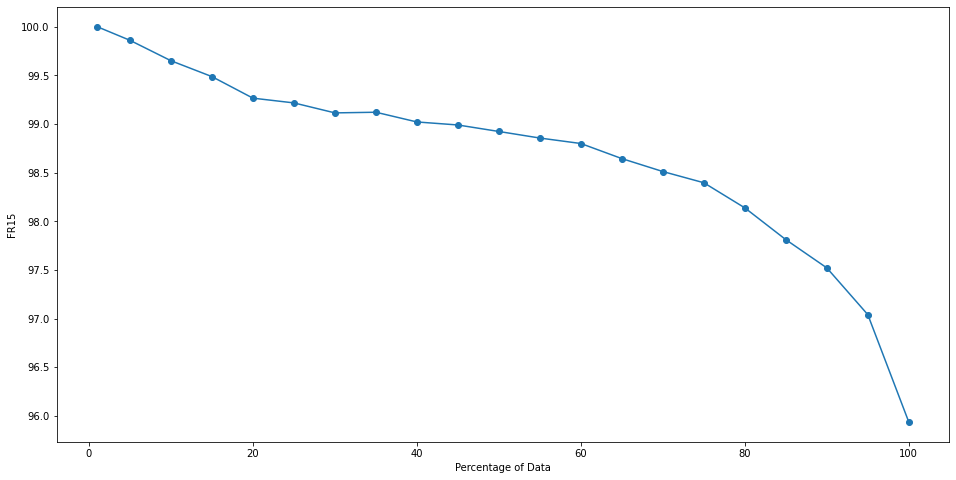

In [26]:
plt.figure(figsize=(16,8))
plt.plot(x,fr15[ind-1],'o-')
plt.xlabel('Percentage of Data')
plt.ylabel('FR15')

Text(0, 0.5, 'FR05')

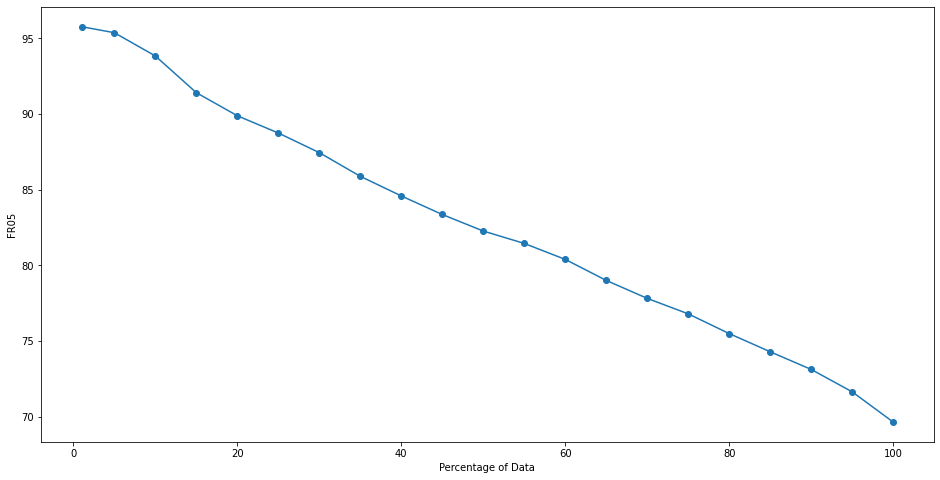

In [27]:
plt.figure(figsize=(16,8))
plt.plot(x,fr05[ind-1],'o-')
plt.xlabel('Percentage of Data')
plt.ylabel('FR05')

Text(0, 0.5, 'BIAS')

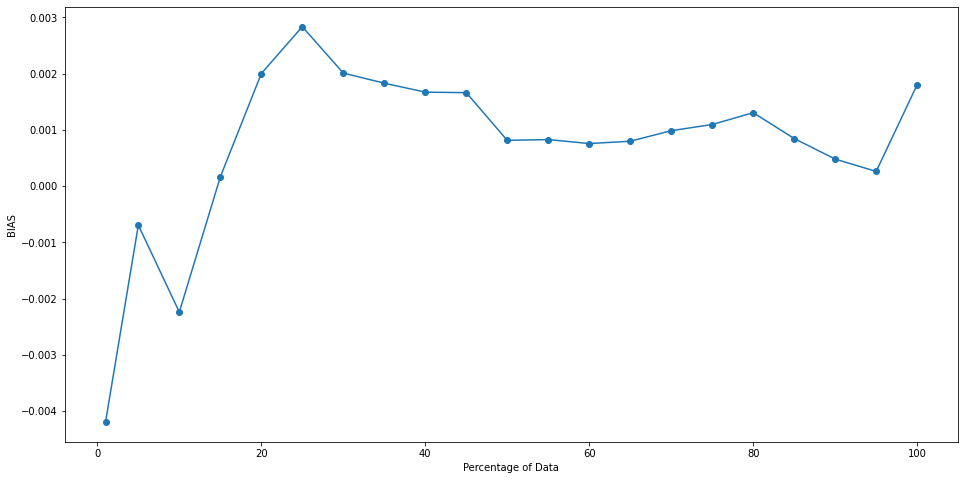

In [28]:
plt.figure(figsize=(16,8))
plt.plot(x,bias[ind-1],'o-')
plt.xlabel('Percentage of Data')
plt.ylabel('BIAS')

Text(0, 0.5, 'Bias')

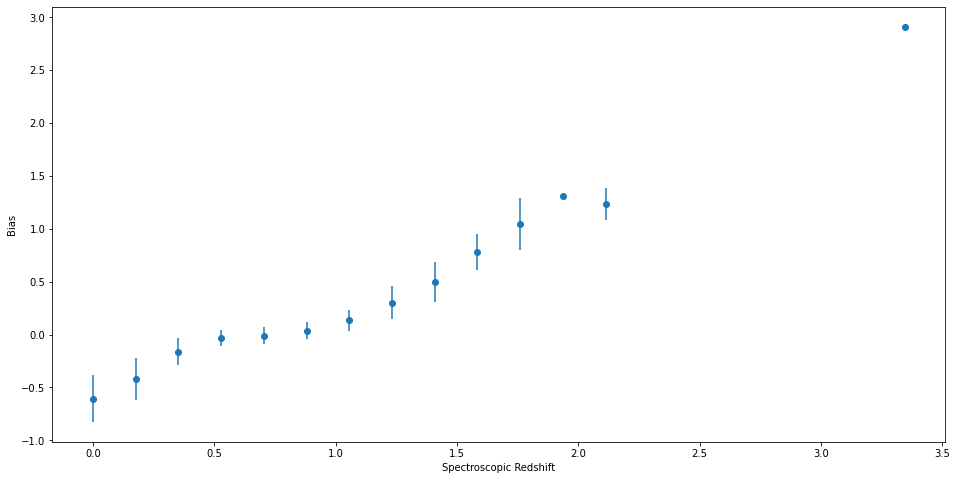

In [29]:
# plot mean and standard deviation of different scores as functions of spectroscopic redshift using 20 bins
plt.figure(figsize=(16,8))
centers,means,stds = GPz.bin(Y[testing],Y[testing]-mu,20)
plt.errorbar(centers,means,stds,fmt='o')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Bias')

Text(0, 0.5, 'Model Uncertainty')

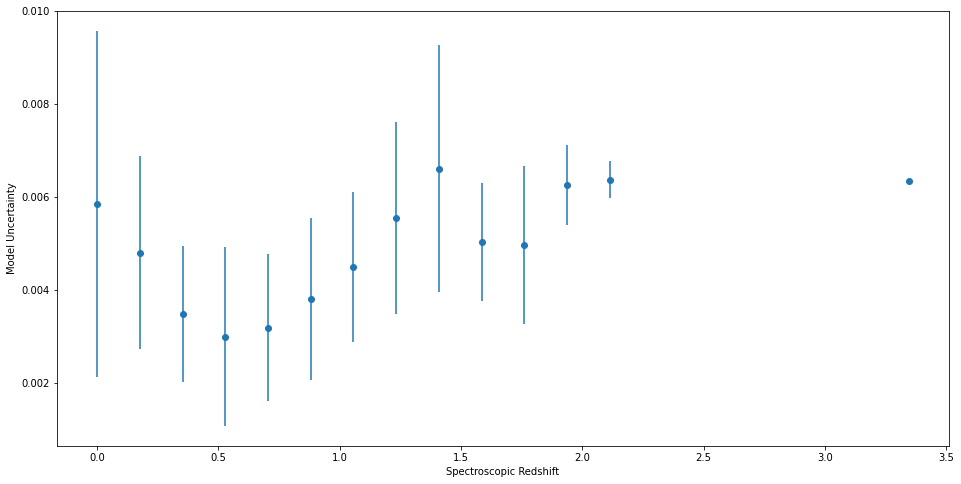

In [30]:
plt.figure(figsize=(16,8))
centers,means,stds = GPz.bin(Y[testing],np.sqrt(modelV),20)
plt.errorbar(centers,means,stds,fmt='o')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Model Uncertainty')

Text(0, 0.5, 'Noise Uncertainty')

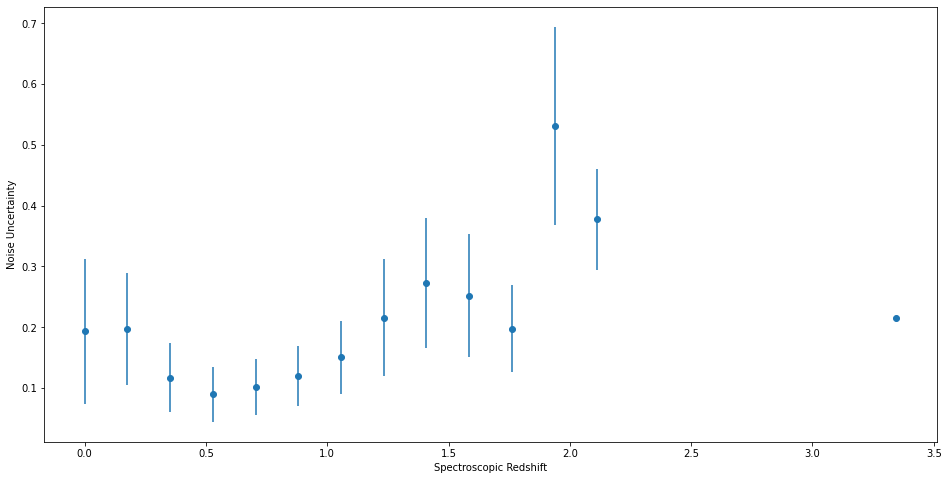

In [31]:
plt.figure(figsize=(16,8))

centers,means,stds = GPz.bin(Y[testing],np.sqrt(noiseV),20)
plt.errorbar(centers,means,stds,fmt='o')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Noise Uncertainty')

In [32]:
error = (mu-Y[testing])

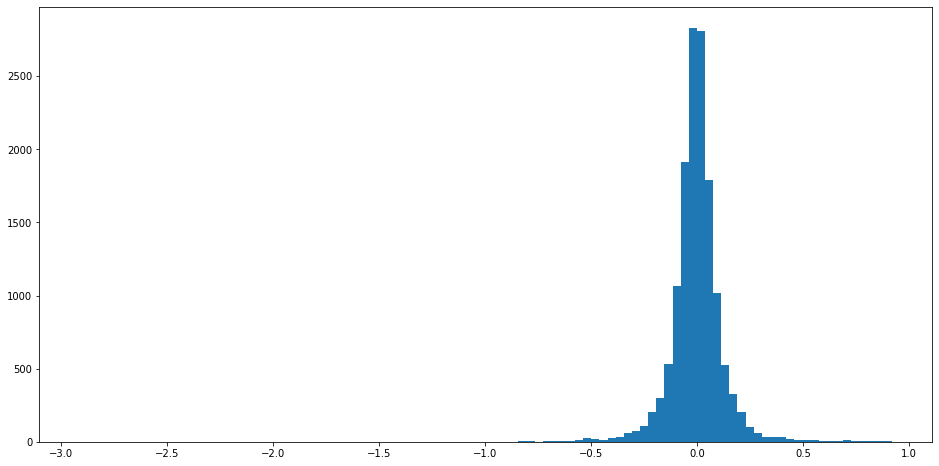

In [33]:
plt.figure(figsize = (16,8))
plt.hist(error,bins = 100);

In [34]:
redshift = pd.DataFrame()
redshift["z_phot"] = mu.flatten()
redshift["z_spec"] = Y[testing].flatten()
redshift["error"] = error

In [35]:
sigma68 = (int(len(error)*0.159),int(len(error)*(1-0.159)))
sigma68

(2273, 12024)

In [36]:
err = np.sort(error,0)

In [37]:
sigma68 = (int(len(err)*0.159),int(len(err)*(1-0.159)))

print("$\sigma_{68}$ error is ", err[sigma68[0]],err[sigma68[1]])

$\sigma_{68}$ error is  [-0.08353802] [0.08131317]


In [38]:
sigma68_arr = err[2273:12024]


In [39]:
x = np.array(range(0,20+1))*5
x[0]=1

ind = x*len(sigma68_arr)//100

In [40]:
zphot = redshift["z_phot"].values

In [41]:
sigma68_arr.shape

(9751, 1)

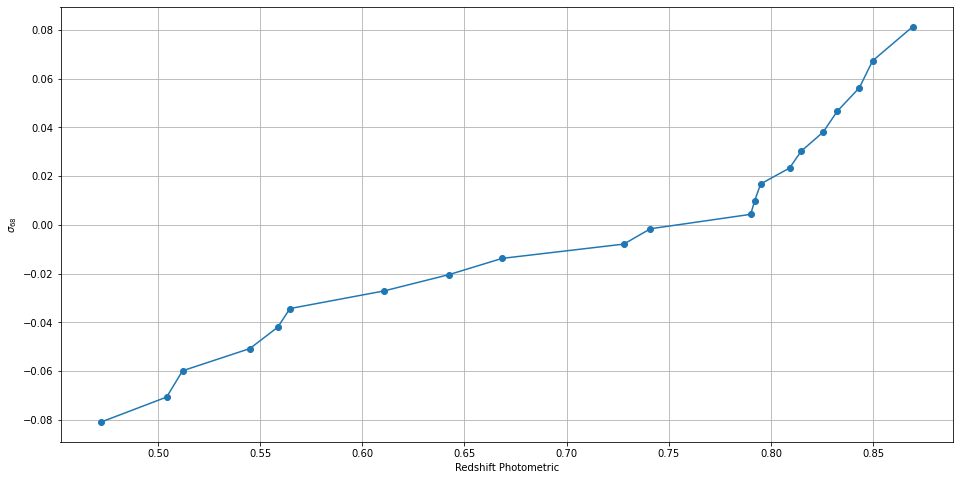

In [42]:
plt.figure(figsize = (16,8))
plt.plot(np.sort(zphot[ind-1]),sigma68_arr[ind-1],'o-')
#plt.scatter(test.z_phot[ind-1],test.error[ind-1],s = 10, c = "red")
#plt.ylim(0)
plt.grid()
plt.xlabel("Redshift Photometric")
plt.ylabel("$\sigma_{68}$")
plt.savefig("plots/gpz_sigma68.png",dpi = 300)

In [43]:
import metrics
result = metrics.compute_metrics(redshift["z_spec"].values,zphot,"ann-rafael")

In [44]:
result.to_frame()

,ann-rafael
RMSE_znorm,0.081042
bias_znorm,0.004685
std_znorm,0.080907
RMSE,0.128690
|znorm| > 0.15 (%),4.063505
|znorm| > 3std (%),1.538677
scatter,0.081042
bias,0.047212
fr015,95.936495
sigma68,0.081313


In [45]:
fr15[-1]

95.93649461463141

In [46]:
# save output as a comma seperated values (mean,sigma,model_variance,noise_variance)
np.savetxt(method+'_'+str(m)+'_'+csl_method+'.csv', np.array([mu,sigma,modelV,noiseV])[:,:,0].T, delimiter=',')

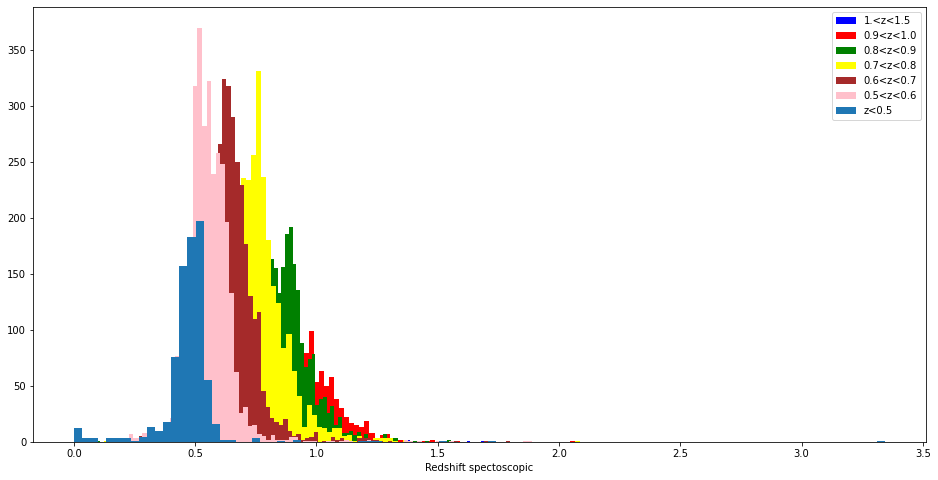

In [47]:
plt.figure(figsize=(16,8))
plt.hist(redshift[(redshift["z_phot"] > 1.) & (redshift["z_phot"] < 1.5)]["z_spec"].values,label = "1.<z<1.5",bins = 100, color = "b")
plt.hist(redshift[(redshift["z_phot"] > 0.9) & (redshift["z_phot"] < 1.)]["z_spec"].values,label = "0.9<z<1.0",bins = 100,color = "r")
plt.hist(redshift[(redshift["z_phot"] > 0.8) & (redshift["z_phot"] < 0.9)]["z_spec"].values,label = "0.8<z<0.9",bins = 100,color = "g")
plt.hist(redshift[(redshift["z_phot"] > 0.7) & (redshift["z_phot"] < 0.8)]["z_spec"].values,label = "0.7<z<0.8",bins = 100,color = "yellow")
plt.hist(redshift[(redshift["z_phot"] > 0.6) & (redshift["z_phot"] < 0.7)]["z_spec"].values,label = "0.6<z<0.7",bins = 100,color = "brown")
plt.hist(redshift[(redshift["z_phot"] > 0.5) & (redshift["z_phot"] < 0.6)]["z_spec"].values,label = "0.5<z<0.6",bins = 100,color = "pink")
plt.hist(redshift[redshift["z_phot"] < 0.5]["z_spec"].values,label = "z<0.5",bins = 100)
plt.xlabel("Redshift spectoscopic")
plt.legend()

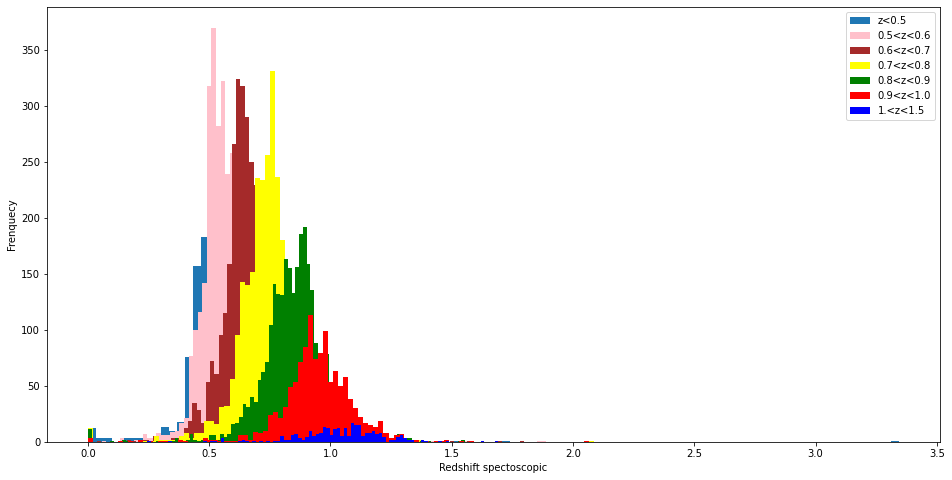

In [48]:
plt.figure(figsize=(16,8))
plt.hist(redshift[redshift["z_phot"] < 0.5]["z_spec"].values,label = "z<0.5",bins = 100)
plt.hist(redshift[(redshift["z_phot"] > 0.5) & (redshift["z_phot"] < 0.6)]["z_spec"].values,label = "0.5<z<0.6",bins = 100,color = "pink" )
plt.hist(redshift[(redshift["z_phot"] > 0.6) & (redshift["z_phot"] < 0.7)]["z_spec"].values,label = "0.6<z<0.7",bins = 100,color = "brown")
plt.hist(redshift[(redshift["z_phot"] > 0.7) & (redshift["z_phot"] < 0.8)]["z_spec"].values,label = "0.7<z<0.8",bins = 100,color = "yellow")
plt.hist(redshift[(redshift["z_phot"] > 0.8) & (redshift["z_phot"] < 0.9)]["z_spec"].values,label = "0.8<z<0.9",bins = 100,color = "g")
plt.hist(redshift[(redshift["z_phot"] > 0.9) & (redshift["z_phot"] < 1.)]["z_spec"].values,label = "0.9<z<1.0",bins = 100,color = "r")
plt.hist(redshift[(redshift["z_phot"] > 1.) & (redshift["z_phot"] < 1.5)]["z_spec"].values,label = "1.<z<1.5",bins = 100,color = "b")
plt.xlabel("Redshift spectoscopic")
plt.ylabel("Frenquecy")
plt.legend()

In [49]:
testing.shape

(47658,)

In [50]:
final_data = pd.DataFrame()
final_data["z"] = Y[testing].flatten()
final_data["gpz:z"] = mu
final_data["error"] = error
final_data["Model Uncertaties"] = modelV
final_data["Noise"] = noiseV
final_data['MAG_AUTO_G_DERED'] = X[testing,0]
final_data['MAG_AUTO_R_DERED'] = X[testing,1]
final_data['MAG_AUTO_I_DERED'] = X[testing,2]
final_data['MAG_AUTO_Z_DERED'] = X[testing,3]
final_data['MAG_AUTO_Y_DERED'] = X[testing,4]


In [51]:
#final_data.to_csv("gpz-rafael-results.csv",index = False)

# PDF

In [52]:
mean = mu[0][0]
var = sigma[0][0]

In [53]:
var

0.012239576922768098

In [54]:
from scipy.stats import norm
# generate random numbers from N(0,1)
#data_normal = norm.rvs(size=200,loc=mu[0],scale=sigma[0])
x_plot = np.linspace(0,3.5,200)
pdf_normal = norm.pdf(x_plot,loc = 0.5040107149907308,scale=0.00745012705216576)

(0.0, 1.5)

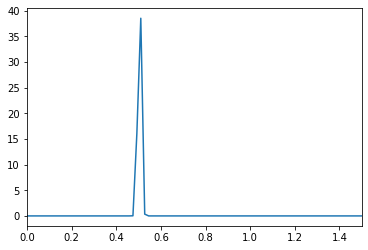

In [55]:
plt.plot(x_plot,pdf_normal)
plt.xlim(0,1.5)

In [56]:
pdf_gpz = []
for i in range(len(mu)):
    pdf_normal = norm.pdf(x_plot,loc = mu[i],scale=sigma[i])
    pdf_gpz.append(pdf_normal)

In [57]:
en(pdf_gpz[:][0]

SyntaxError: unexpected EOF while parsing (<ipython-input-57-0515fb760028>, line 1)

In [ ]:
plt.plot(x_plot,np.sum(pdf_gpz[:][:],axis=0))

In [59]:
sigma[0]

array([0.01223958])

In [60]:
noiseV[0] + modelV[0]

array([0.01223958])